## TP3 Regresión lineal con scikit-learn puro

In [61]:
%env OMP_NUM_THREADS=2
%env MKL_NUM_THREADS=2

env: OMP_NUM_THREADS=2
env: MKL_NUM_THREADS=2


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

#### 1. Carga de datos

Los 3 datasets tienen la misma forma, una columna con 500 filas:

$$ x \in \mathbb{R}; ~ t \in \mathbb{R} $$ 

In [63]:
X_all = np.loadtxt("datasets/dataset-2-training-Entradas.txt")
t_all = np.loadtxt("datasets/dataset-2-training-targets.txt")
X_unknown = np.loadtxt("datasets/dataset-2-Entradas.txt")

X_all = np.asarray(X_all).reshape(-1, 1)
t_all = np.ravel(t_all)
X_unknown = np.asarray(X_unknown).reshape(-1, 1)

# División de datos
X_train, X_val, t_train, t_val = train_test_split(X_all, t_all, test_size=0.2, random_state=42)
print("Shapes:", X_train.shape, t_train.shape, X_val.shape, t_val.shape)

Shapes: (400, 1) (400,) (100, 1) (100,)


#### 2. Modelos: polinomio y RBF

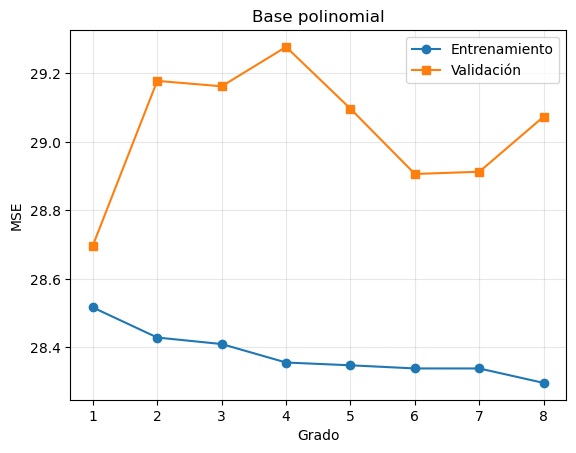

In [64]:
alph = 1e-3   # regularización

# --- Polinomios ---
degrees = [1,2,3,4,5,6,7,8]
poly_train_mse, poly_val_mse = [], []
for d in degrees:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(d, include_bias=True)),
        ("ridge", Ridge(alpha=alph, fit_intercept=False))
    ])
    pipe.fit(X_train, t_train)
    poly_train_mse.append(mean_squared_error(t_train, pipe.predict(X_train)))
    poly_val_mse.append(mean_squared_error(t_val, pipe.predict(X_val)))

plt.plot(degrees, poly_train_mse, "o-", label="Entrenamiento")
plt.plot(degrees, poly_val_mse, "s-", label="Validación")
plt.xlabel("Grado")
plt.ylabel("MSE")
plt.title("Base polinomial")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

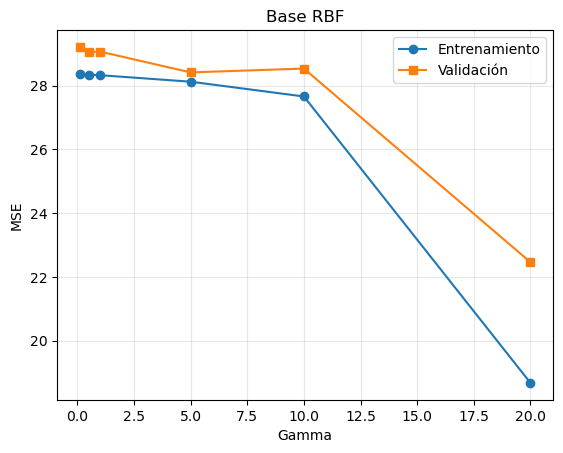

In [65]:
# --- RBF ---
gammas = [0.1, 0.5, 1.0, 5.0, 10.0, 20.0]
rbf_train_mse, rbf_val_mse = [], []
for g in gammas:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("rbf", RBFSampler(gamma=g, n_components=100, random_state=42)),
        ("ridge", Ridge(alpha=alph, fit_intercept=False))
    ])
    pipe.fit(X_train, t_train)
    rbf_train_mse.append(mean_squared_error(t_train, pipe.predict(X_train)))
    rbf_val_mse.append(mean_squared_error(t_val, pipe.predict(X_val)))

plt.plot(gammas, rbf_train_mse, "o-", label="Entrenamiento")
plt.plot(gammas, rbf_val_mse, "s-", label="Validación")
plt.xlabel("Gamma")
plt.ylabel("MSE")
plt.title("Base RBF")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

### 3. Selección del mejor

In [66]:
best_poly_deg = degrees[np.argmin(poly_val_mse)]
best_rbf_gamma = gammas[np.argmin(rbf_val_mse)]

print("Mejor polinomio:", best_poly_deg, "Val MSE:", min(poly_val_mse))
print("Mejor RBF gamma:", best_rbf_gamma, "Val MSE:", min(rbf_val_mse))

Mejor polinomio: 1 Val MSE: 28.69756788248994
Mejor RBF gamma: 20.0 Val MSE: 22.464327709392514


#### 4. entrenamiento final + predicción

In [67]:
# ejemplo: elegimos polinomio si es mejor
pipe_final = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(best_poly_deg, include_bias=True)),
    ("ridge", Ridge(alpha=alph, fit_intercept=False))
])
pipe_final.fit(X_all, t_all)
y_unknown = pipe_final.predict(X_unknown)
np.savetxt("predicciones_unknown.txt", y_unknown, fmt="%.6f")

#### 5. Distribución predictiva para primer x_unknown

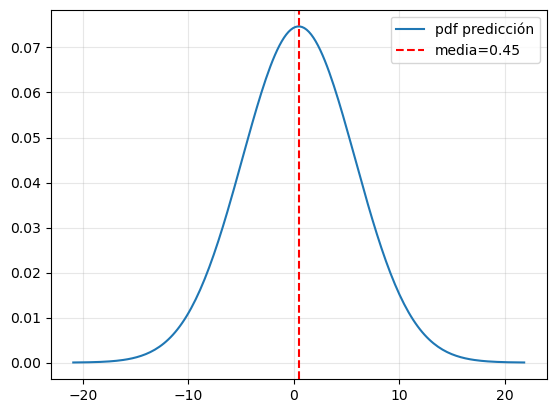

In [68]:
residuals = t_all - pipe_final.predict(X_all)
sigma2_hat = np.var(residuals)

mu = float(y_unknown[0])
std = np.sqrt(sigma2_hat)
xs = np.linspace(mu-4*std, mu+4*std, 200)
pdf = (1/(std*np.sqrt(2*np.pi)))*np.exp(-0.5*((xs-mu)/std)**2)

plt.plot(xs, pdf, label="pdf predicción")
plt.axvline(mu, color="r", linestyle="--", label=f"media={mu:.2f}")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

#### 6. Bias-variance decomposition (bootstrap)

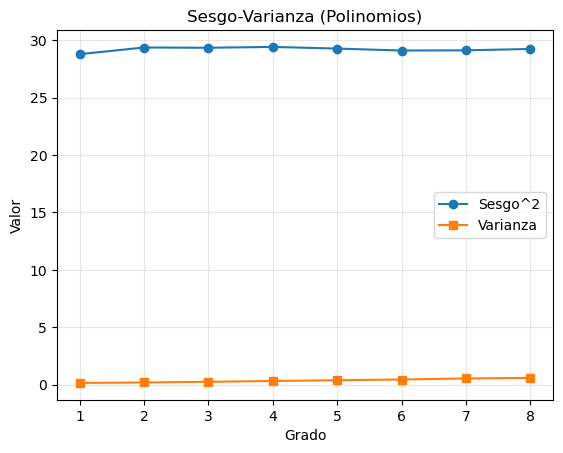

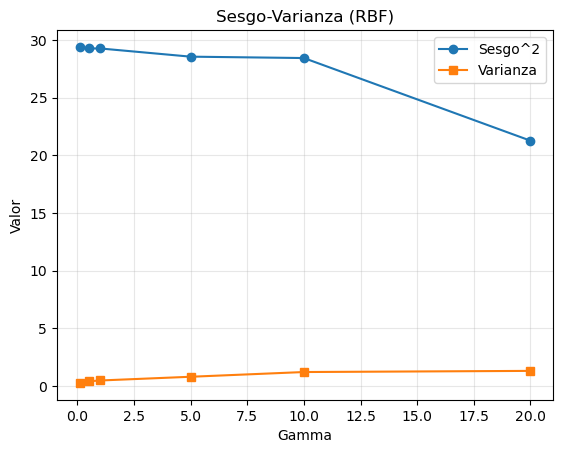

In [69]:
def bias_variance(pipe_factory, X_train, t_train, X_val, t_val, B=50):
    preds = []
    for b in range(B):
        Xb, tb = resample(X_train, t_train, replace=True, random_state=b)
        model = pipe_factory()
        model.fit(Xb, tb)
        preds.append(model.predict(X_val).ravel())
    preds = np.array(preds)  # (B, n_val)
    mean_pred = preds.mean(axis=0)
    var_pred = preds.var(axis=0)
    bias2 = np.mean((mean_pred - t_val.ravel())**2)
    variance = np.mean(var_pred)
    return bias2, variance

# Ejemplo: bias-var para polinomios
biases, vars_ = [], []
for d in degrees:
    def factory(deg=d):
        return Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(deg, include_bias=True)),
            ("ridge", Ridge(alpha=alph, fit_intercept=False))
        ])
    b2, v = bias_variance(factory, X_train, t_train, X_val, t_val)
    biases.append(b2); vars_.append(v)

plt.plot(degrees, biases, "o-", label="Sesgo^2")
plt.plot(degrees, vars_, "s-", label="Varianza")
plt.xlabel("Grado"); plt.ylabel("Valor")
plt.title("Sesgo-Varianza (Polinomios)")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# Bias-var para RBF
biases_r, vars_r = [], []
for g in gammas:
    def factory(gam=g):
        return Pipeline([
            ("scaler", StandardScaler()),
            ("rbf", RBFSampler(gamma=gam, n_components=100, random_state=42)),
            ("ridge", Ridge(alpha=alph, fit_intercept=False))
        ])
    b2, v = bias_variance(factory, X_train, t_train, X_val, t_val)
    biases_r.append(b2); vars_r.append(v)

plt.plot(gammas, biases_r, "o-", label="Sesgo^2")
plt.plot(gammas, vars_r, "s-", label="Varianza")
plt.xlabel("Gamma"); plt.ylabel("Valor")
plt.title("Sesgo-Varianza (RBF)")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()